<a href="https://colab.research.google.com/github/Alvaisari/IMFP-EAL-estimator/blob/main/IMFP_EAL_estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Created by [Konstantin Tumashevich](https://www.linkedin.com/in/konstantin-tumashevich)

<H1> Introduction </H1>

Welcome to this Colab Notebook, designed to provide you with various methods for estimating the inelastic mean free path (IMFP) and electron effective attenuation length (EAL) for pure water.

[IMFP](https://doi.org/10.1016/S0368-2048(99)00044-4) is the average of distances, measured along the trajectories, that particles with a given energy travel between inelastic collisions in a substance.

[EAL](https://doi.org/10.1016/S0368-2048(99)00044-4) is the average emission function decay length when the emission depth distribution function is sufficiently close to exponential for a given application.

In summary, the main difference between EAL and IMFP lies in the focus of their calculations.
EAL considers the attenuation of electron intensity due to a combination of elastic and inelastic scattering, while IMFP concentrates on the distance traveled by an electron before its energy is significantly altered due to inelastic interactions.
Both parameters are important in understanding the behavior of electrons within materials, particularly in techniques like electron spectroscopy and microscopy.

Theory-based approaches:

*   IXS-D3 model by [Emfietzoglou and Nikjoo, 2007](https://doi.org/10.1667/RR0551.1). The model was developed for the 0.1–10 keV range based on a dielectric response model for liquid water.
*   Relativistic TPP-2M model (coefficients are from the relativistic extended Mermin method) by [Shinotsuka et al, 2015](https://doi.org/10.1002/sia.5789), initial formula was developed by [Tahuma et al, 1994](https://doi.org/10.1002/sia.740210302) for estimating IMFPs in elements, inorganic compounds and organic compounds over the 50–2000 eV range.
*   Relativistic full Penn algorithm applied by [Shinotsuka et al, 2017](https://doi.org/10.1002/sia.6123). IMFPs were calculated for liquid water from its optical energy-loss function for electron energies from 50 eV to 30 keV.

Experiment-based approaches:

*   [Ottosson et al, 2010](https://doi.org/10.1016/j.elspec.2009.08.007) estimated the electron kinetic energy dependent probing depth (EAL) via the relative water O 1s phototelectron signal as a function of photon energy, constant β was assumed for 1s ionization. The anisotropy parameter
β depends on the subshell and kinetic energy.
*   [Thürmer et al, 2013](https://doi.org/10.1103/PhysRevLett.111.173005) corrected EAL values obtained by [Ottosson et al, 2010](https://doi.org/10.1016/j.elspec.2009.08.007)  for the new electron kinetic energy dependent β.

Regarding experimental approach, [Thürmer et al, 2013](https://doi.org/10.1103/PhysRevLett.111.173005) recommend using modified theoretical curve initially developped by [Tomita et al, 1997](https://doi.org/10.1007/s004110050061) for kinetic energies below 100 and experimental EAL values above 100 eV.
That was implemented in this notebook.

**IMPORTANT NOTE**

At very low kinetic energies (below 100 eV), the interactions become more complex due to multiple scattering processes and the probing depth values in this kinetic energy region are unreliable.

Overall, there is still no consensus on which method of IMFP estimation is the best.

In [ ]:
# @markdown # Run the cell to import libraries and functions


import pandas as pd
import numpy as np
from math import log, pi
from scipy.optimize import curve_fit
import seaborn as sns
import plotly.graph_objects as go

# to avoid annoying messages about zero divisions
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

def fitCurve(x, y, newx):
    ''''''
    # define the true objective function
    # Mott-Littleton equation, to fit IMFP/EAL data
    def objective(x, a, b, m, n):
        return a / x**m + b / x**n

    # get optimal parameter values
    popt, _ = curve_fit(objective, x, y)
    a, b, m, n = popt

    return objective(newx, a, b, m, n)


def IXSD3(E):
    '''IXS-D3 model, Emfietzoglou and Nikjoo, 2007, DOI:

    input kinetic energy in eV
    return IMFP in nm
    '''
    A, B, C = 55.36, -135.1, -5728
    try:
        return 1/(A*log(E)/E + B/E + C/E**2)
    except ValueError as e:
        print('[ERR]', E, 'is under log')
        raise e


def relativistic_TPP2M(E, model='EM'):
    '''Shinotsuka, 2015, DOI: 10.1002/sia.5789
    Shinotsuka, 2017, DOI:10.1002/sia.6123

    EM - extended Mermin

    input kinetic energy in eV
    return IMFP in nm
    '''
    if model == 'EM':
        β = 0.145 # 1/eV * 1/nm
        γ = 0.1828 # 1/eV
        C = 14.73 # 1/nm
        D = 334.1 # eV/nm

    Ep = 19.202 # eV, Fermi level for water
    def α(E): return (1 + (E/(2*510998.9))) / (1+(E/510998.9))**2

    return α(E) * E / (
        Ep**2 * (β * np.log(γ * α(E) * E) - (C/E) + (D/E**2))
    )


# Shinotsuka, 2017, DOI:10.1002/sia.6123. I take only up to 2200 eV
relativistic_full_Penn = {
    'Ekin': np.array(
        [54.6, 60.3, 66.7, 73.7, 81.5, 90.0, 99.5, 109.9, 121.5, 134.3, 148.4,
         164.0, 181.3, 200.3, 221.4, 244.7, 270.4, 298.9, 330.3, 365.0, 403.4,
         445.9, 492.7, 544.6, 601.8, 665.1, 735.1, 812.4, 897.8, 992.3, 1096.6,
         1212.0, 1339.4, 1480.3, 1636.0, 1808.0, 1998.2, 2208.3, 2440.6, 2697.3,
         2981.0, 3294.5, 3640.9, 4023.9, 4447.1, 4914.8, 5431.7, 6002.9, 6634.2,
         7332.0, 8103.1, 8955.3, 9897.1, 10938.0, 12088.4, 13359.7, 14764.8,
         16317.6, 18033.7, 19930.4, 22026.5, 24343.0, 26903.2, 29732.6][:38]
    ),
    'IMFP': np.array(
        [0.986, 0.967, 0.956, 0.954, 0.958, 0.969, 0.986, 1.01, 1.04, 1.07,
         1.12, 1.17, 1.22, 1.28, 1.35, 1.43, 1.52, 1.61, 1.72, 1.84, 1.96, 2.1,
         2.26, 2.42, 2.6, 2.8, 3.02, 3.26, 3.51, 3.79, 4.1, 4.43, 4.8, 5.19,
         5.62, 6.09, 6.6, 7.16, 7.77, 8.43, 9.15, 9.93, 10.78, 11.71, 12.72,
         13.83, 15.03, 16.33, 17.75, 19.3, 20.99, 22.82, 24.81, 26.97, 29.32,
         31.87, 34.64, 37.65, 40.9, 44.42, 48.23, 52.35, 56.8, 61.6][:38]
    )
}
# based on figures from Turmer 2013
modified_Tomitta = {
    'Ekin': [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
             90, 95],
    'IMFP': [1.48997, 1.33479, 1.28138, 1.25523, 1.24141, 1.23327, 1.22813,
             1.22487, 1.22276, 1.22127, 1.22029, 1.21954, 1.21896,
             1.21863, 1.21829, 1.21808, 1.21797]
}
Ottosson_experimental = {
    'Ekin': np.array(
        modified_Tomitta['Ekin'] + [100.0, 150.42, 201.82, 298.66, 400.72,
                                    507.78, 602.76, 703.91, 815.36, 914.1]
    ),
    'IMFP': np.array(
        modified_Tomitta['IMFP'] + [1.56, 1.31, 1.31, 1.52, 2.17,
                                    2.5, 3.14, 3.39, 4.1, 5.28]
    )
}
Turmer_experimental = {
    'Ekin': np.array(
        modified_Tomitta['Ekin'] + [100, 150, 200, 300, 400,
                                    500, 600, 700, 800, 900]
    ),
    'IMFP': np.array(
        modified_Tomitta['IMFP'] + [1.22696, 1.28715, 1.47795, 1.77832,
                                    2.53291, 2.9469, 3.73475, 4.07042,
                                    4.87968, 6.32858]
    )
};

In [ ]:
#@markdown # Enter kinetic energy values in the field below separating values by space.
# markdown # Check **correct_for_LJ** if the 2/pi correction for cylindrical shape is required.
#@markdown # Then run the cell.

Kinetic_energy_eV = "75 100 500 1000" #@param {type:"string"}
Kinetic_energy_eV = sorted([float(i) for i in Kinetic_energy_eV.split()])

#correct_for_LJ = False # @param {type:"boolean"}
#coef = 1
#if correct_for_LJ:
#    coef = 2/pi

# create dataframe and fill in Ekin and IMFP values
def create_IMFP_dataframe(Ekin_array):
    IMFP = pd.DataFrame()
    IMFP['Ekin [eV]'] = Ekin_array

    IMFP['IXS-D3 [nm]'] = np.array([IXSD3(ek) for ek in IMFP['Ekin [eV]'].values])
    IMFP['Relativistic TPP2M [nm]'] = np.array([relativistic_TPP2M(ek) for ek in IMFP['Ekin [eV]'].values])

    IMFP['Relativistic full Penn [nm]'] = fitCurve(
        relativistic_full_Penn['Ekin'],
        relativistic_full_Penn['IMFP'],
        IMFP['Ekin [eV]'])

    IMFP['Ottosson et al, 2010 (EAL) [nm]'] = fitCurve(
        Ottosson_experimental['Ekin'],
        Ottosson_experimental['IMFP'],
        IMFP['Ekin [eV]'])

    IMFP['Turmer et al, 2013 (EAL) [nm]'] = fitCurve(
        Turmer_experimental['Ekin'],
        Turmer_experimental['IMFP'],
        IMFP['Ekin [eV]'])

    return IMFP

# user data ponts
full_IMFP = create_IMFP_dataframe(np.linspace(min(Kinetic_energy_eV), max(Kinetic_energy_eV), 100))
user_IMFP = create_IMFP_dataframe(np.array(Kinetic_energy_eV))

display(user_IMFP)

fig = go.Figure()
seaborn_colors = sns.color_palette()
plotly_colors = ['rgb({},{},{})'.format(int(c[0]*255),
                                        int(c[1]*255),
                                        int(c[2]*255)) for c in seaborn_colors]

for ind, key in enumerate(full_IMFP.columns[1:]):
    fig.add_scatter(
        x=full_IMFP['Ekin [eV]'],
        y=full_IMFP[key],
        name=key,
        showlegend=False,
        legendgroup=key,
        mode='lines',
        marker=dict(color=plotly_colors[ind])
        )

    fig.add_scatter(
        x=user_IMFP['Ekin [eV]'],
        y=user_IMFP[key],
        name=key,
        legendgroup=key,
        mode='markers',
        marker=dict(
            size=14,
            opacity=0.8,
            color=plotly_colors[ind]
            )
        )

fig.update_layout(
    title_text='IMFP and EAL with different approaches',
    title_font_size=20,
    width=1000,
    height=600,
    xaxis_title='Kinetic energy [eV]',
    yaxis=dict(
        title='Probing depth [nm]',
        # autorange='reversed'
        ),
    font=dict(size=16),
    legend_title='Dots are user input<br>Lines are data fits<br>',
    template='seaborn'
    )

fig.show()

,Ekin [eV],IXS-D3 [nm],Relativistic TPP2M [nm],Relativistic full Penn [nm],"Ottosson et al, 2010 (EAL) [nm]","Turmer et al, 2013 (EAL) [nm]"
0,75.0,2.723034,0.838294,0.960054,1.239616,1.216544
1,100.0,1.598409,0.881987,0.995678,1.244573,1.231668
2,500.0,2.531842,2.161753,2.272867,2.436259,2.913741
3,1000.0,4.139324,3.652327,3.821517,5.774817,7.008128


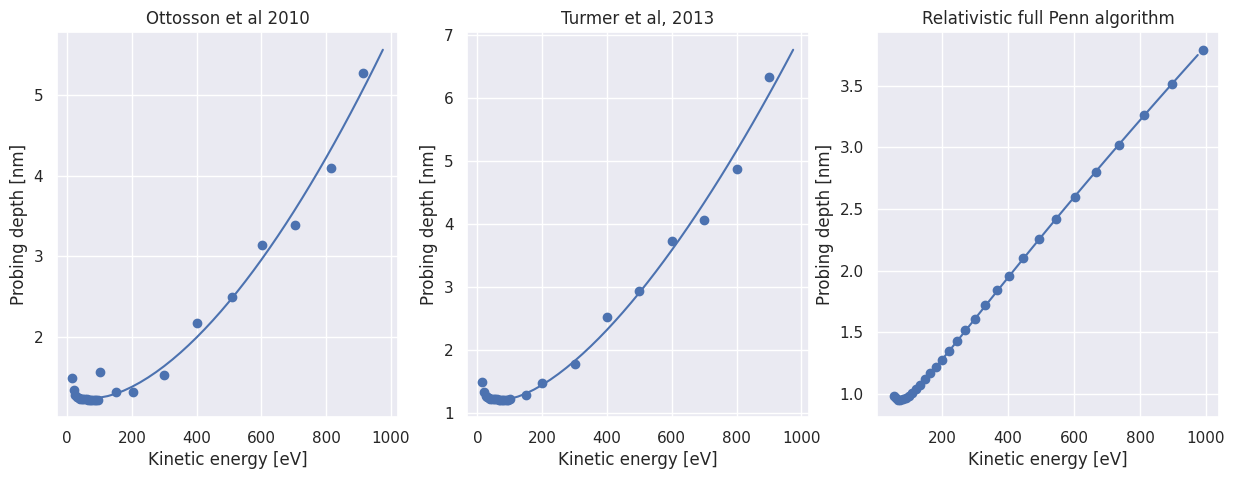

In [ ]:
#@markdown # Cheking how fare are fitting curves

#@markdown In case of Ottosson et al 2010, Turmer et al, 2013, and relativistic
#@markdown full Penn algorithm the datapoints from literature were fit with the
#@markdown Mott-Littleton equation. Even though curves are close, the shape
#@markdown certainly does not go through all points.
#@markdown The fairness of the fit can be estimated based on the plots below.

import matplotlib.pyplot as plt
sns.set()

new_Ekin = np.arange(50, 1000, 25)

fig, axes = plt.subplots(1,3, figsize=(15,5))

data_to_fit = {
    'Ottosson et al 2010': Ottosson_experimental,
    'Turmer et al, 2013': Turmer_experimental,
    'Relativistic full Penn algorithm': relativistic_full_Penn
}
for ax, key in zip(axes, data_to_fit.keys()):
    x = data_to_fit[key]['Ekin']
    y = data_to_fit[key]['IMFP']

    ax.scatter(x[x<1000],y[x<1000])

    ax.plot(
        new_Ekin,
        fitCurve(x, y, new_Ekin)
        )

    ax.set(
        xlabel='Kinetic energy [eV]',
        ylabel='Probing depth [nm]',
        title=key
    )